<a href="https://colab.research.google.com/github/cristianegea/Aurelien_Geron_Hands_on_Machine_Learning/blob/main/2_End_to_End_Machine_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Livro: Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems

# Autor: Aurélien Géron

# Chapter 2 - End-to-End Machine Learning Project

# 1. Performance Measure

**Raiz quadrata do erro quadrático médio (RMSE)**: fornece uma ideia do quanto o sistema está errando em suas predições, com um peso alto para erros grandes.

$$
\text{RMSE} (\mathbf{X},h) = \sqrt{\frac{1}{m} \sum^m_{i=1} \left(h(\mathbf{x^{(i)}}) - y^{(i)} \right)^2 }
$$

onde $m$ é o número de instâncias na dataset, $\mathbf{x^{(i)}}$ é um vetor de todos os valores de features da $i$-ésima instância no dataset e $y^{(i)}$ é o seu rótulo (valor do output desejado para a instância), $h$ é a função de predição do sistema (chamada de hipótese). $\text{RMSE} (\mathbf{X},h)$ é a função de custo mensurada sobre o conjunto de exemplos utilizando a hipótese $h$. $\mathbf{X}$ é a matriz contendo todos os valore de features (com exceção dos rótulos) de todas as instâncias no dataset.

$$
\mathbf{X} = \left[\mathbf{x^{(1)}} \ \ \mathbf{x^{(2)}} \ \ \dots \ \ \mathbf{x^{(m)}} \right]
$$

Quando o sistema recebe um vetor de feature $\mathbf{x^{(1)}}$ de instâncias, ele gera um valor predito $\hat{y}^{(i)} = h(\mathbf{x^{(i)}})$ para a instância.

**Erro médio absoluto (MAE)**: fornece uma medida do desvio absoluto médio do sistema.

$$
\text{MAE} (\mathbf{X},h) = \frac{1}{m} \sum^m_{i=1} \left|h(\mathbf{x^{(i)}}) - y^{(i)} \right|
$$

# 2. Take a Quick Look at the Data Structure

**Informação**: Utilização de dados do censo da Califórnia para construção de um modelo de preços de habitação neste estado. Estesb dados incluem população, renda média e mediana do preço de habitação por grupos de blocos (unidades geograficamente menores, contendo aproximadamente de 600 a 3000 pessoas).

Obs.: O autor chama estes grupos de blocos de "distritos".

O modelo deverá aprender a partir destes dados e ser capaz de predizer a mediana do preço de habitação em qualquer distrito, dada as demais métricas.

## 2.1. Setup

In [1]:
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 2.2. Get the data

In [2]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

Criação de um diretório (*datasets/housing*) no workspace, download do arquivo *housing.tgz* e extração do arquivo *housing.csv*.

In [3]:
fetch_housing_data()

In [4]:
# Load the data

import pandas as pd

# Função para retornar um objeto DataFrame do pandas contendo todos os dados
def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

## 2.3. Take a Quick Look at the Data Structure

In [5]:
# Inspeção das 5 primeiras linhas 
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Cada linha representa 1 distrito e cada coluna representa um atributo.

In [6]:
# Descrição dos dados
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


* O dataset possui 20640 instâncias.

* O atributo `total_bedrooms` possui somente 20433 valores não nulos, significando que 207 há 207 distritos com NA.

* Todos os atributos são numéricos, com exceção de `ocean_proximity`, que é do tipo objeto (atributo categórico).

In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
# Summary of the numerical attributes
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


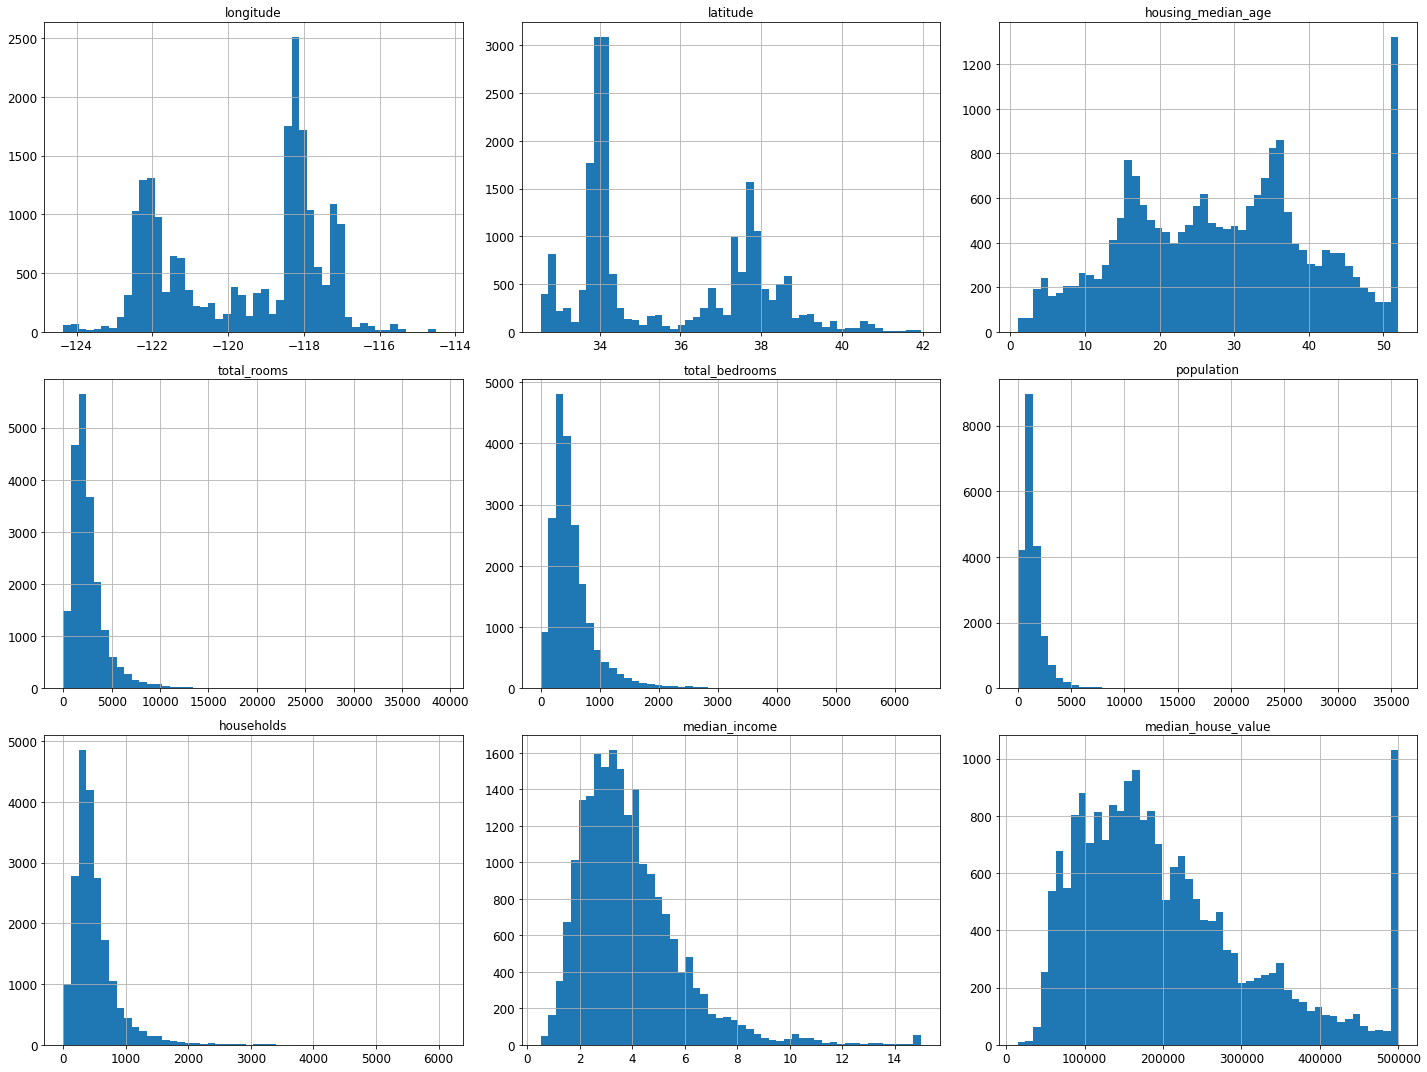

In [9]:
# Histogram for each numerical attibute

%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

# 3. Create a Test Set

In [10]:
# to make this notebook's output identical at every run
# to set the random number generator's seed (it always generates the same shuffled indices)
np.random.seed(42)

In [11]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [16]:
from sklearn.model_selection import train_test_split

# to split datasets into multiples subsets
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

# "random_state" permite a construção do gerador "np.random.seed"

len(train_set)

16512

In [17]:
len(test_set)

4128

# 4. Discover and Visualize the Data to Gain Insights

## 4.1. Visualizing Geographical Data

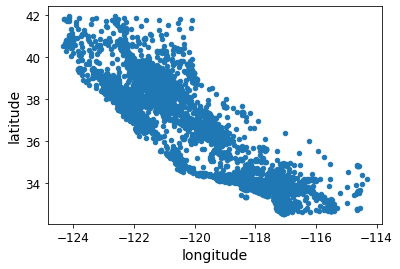

In [18]:
# Scatterplot of all districts
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude')

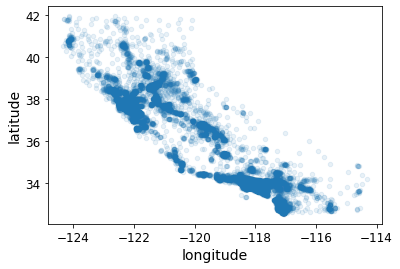

In [19]:
# the places where is a high density of data points
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.1)

Saving figure housing_prices_scatterplot


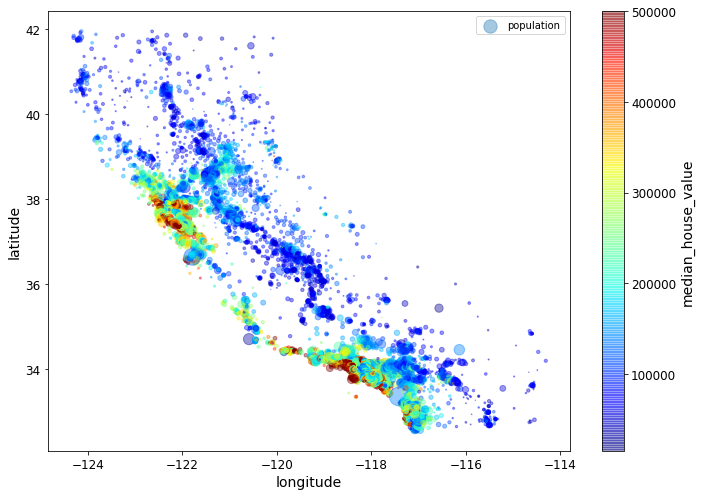

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

## 4.2. Looking for Correlations

In [21]:
# standard correlation coefficient (pearson)
corr_matrix = housing.corr()

In [22]:
# how mmuch each attribute correlates with the median house value
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

O coeficiente de correlação vai de -1 até +1.

* Quando o coeficiente está próximo de +1, então há uma forte correlação positiva.

* Quando o coeficiente está próximo de -1, então há uma forte correlação negativa.

* Quando o coeficiente está próximo de 0, não há uma correlação linear.

Obs.: o coeficiente de correlação somente mede correlações lineares.

Saving figure scatter_matrix_plot


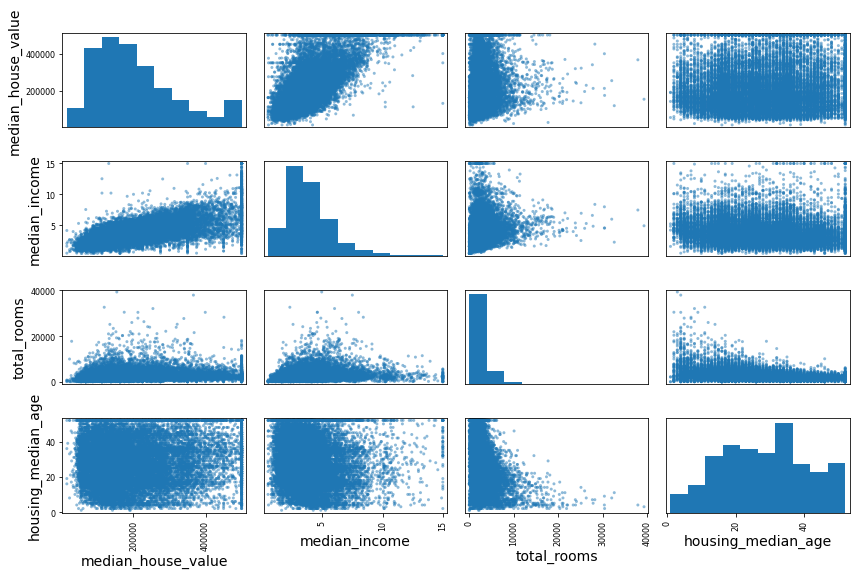

In [23]:
# Correlation Matrix - Every numerical attribute against every other numerical attribute
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure income_vs_house_value_scatterplot


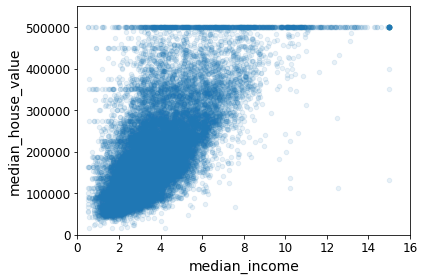

In [24]:
# correlation scatterplot 
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

## 4.3. Experimenting with Attribute Combinations

In [25]:
# create the new attributes
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [ ]:
# correlation_matrix
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

# 5. Prepare the Data for Machine Learning Algorithms

In [26]:
# preparation

# create an income category attribute with 5 categories
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

# stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

# drop labels for training set
housing = strat_train_set.drop("median_house_value", axis=1)  
housing_labels = strat_train_set["median_house_value"].copy()

## 5.1. Data Cleaning

Visto que a maioria dos algoritms de aprendizado de máquinas não consegue trabalhar com features ausentes, é preciso criar alguma função para tratar o dataset.

In [27]:
# Option 1: Get rid of the corresponding districts
housing.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,4.625369,0.223852,2.094395,2
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,6.008850,0.159057,2.707965,5
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,4.225108,0.241291,2.025974,2
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,5.232295,0.200866,4.135977,2
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,4.505810,0.231341,3.047847,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND,6.052381,0.185681,2.728571,4
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND,4.635659,0.245819,4.077519,2
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND,6.346405,0.179609,2.742484,3
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN,5.505618,0.193878,3.808989,3


In [28]:
# Option 2: Get rid of the whole attribute
housing.drop("total_bedrooms", axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,income_cat
17606,-121.89,37.29,38.0,1568.0,710.0,339.0,2.7042,<1H OCEAN,4.625369,0.223852,2.094395,2
18632,-121.93,37.05,14.0,679.0,306.0,113.0,6.4214,<1H OCEAN,6.008850,0.159057,2.707965,5
14650,-117.20,32.77,31.0,1952.0,936.0,462.0,2.8621,NEAR OCEAN,4.225108,0.241291,2.025974,2
3230,-119.61,36.31,25.0,1847.0,1460.0,353.0,1.8839,INLAND,5.232295,0.200866,4.135977,2
3555,-118.59,34.23,17.0,6592.0,4459.0,1463.0,3.0347,<1H OCEAN,4.505810,0.231341,3.047847,3
...,...,...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,573.0,210.0,4.9312,INLAND,6.052381,0.185681,2.728571,4
12053,-117.56,33.88,40.0,1196.0,1052.0,258.0,2.0682,INLAND,4.635659,0.245819,4.077519,2
13908,-116.40,34.09,9.0,4855.0,2098.0,765.0,3.2723,INLAND,6.346405,0.179609,2.742484,3
11159,-118.01,33.82,31.0,1960.0,1356.0,356.0,4.0625,<1H OCEAN,5.505618,0.193878,3.808989,3


In [29]:
# Option 3: Set the values to some value (zero, the mean, the median, etc.)

# compute the median value on the training set
median = housing["total_bedrooms"].median()

# to fill the missing values in the training set
housing["total_bedrooms"].fillna(median, inplace=True)

In [32]:
# class to take care of missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# create a copy of the data without the text attribute ocean_proximity
housing_num = housing.drop("ocean_proximity", axis=1)

# fit the imputer instance to the training data using the fit() method
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [33]:
# computed the median of each attribute and stored the result in its statistics_ instance variable
imputer.statistics_

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11950000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54090000e+00,
        5.23228423e+00,  2.03031374e-01,  2.81765270e+00,  3.00000000e+00])

In [34]:
housing_num.median().values

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11950000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54090000e+00,
        5.23228423e+00,  2.03031374e-01,  2.81765270e+00])

In [38]:
# replacing missing values with the learned medians
X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

## 5.2. Handling Text and Categorical Attributes